# Figure Generation

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fftshift
import seaborn as sns
import matplotlib.pylab as pl
import bites as bt
from os import sep
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation
from IPython.display import HTML, display


In [2]:
plt.rcParams['pdf.fonttype'] = 42

Extract data directory and metadata. 

In [3]:
dataDir = 'raw/JK_biting_paper_trained_data_04092025'
metaDat = 'video_parameters_04172025.csv'
plot_folder = r"plots/"

In [4]:
datasetDf = pd.read_csv(sep.join([dataDir, metaDat])).rename(columns={'Unnamed: 0': 'video'})
datasetDf['path'] = datasetDf['video'].apply(lambda x: sep.join([dataDir, x.replace('vid', dataDir.split(sep)[-1].split('_')[-1])]))
datasetDf['filename'] = datasetDf['video'].apply(lambda x: x.replace('vid','data')+'.csv')
datasetDf['videofile'] = datasetDf['video'].apply(lambda x: x+'.mp4')

In [5]:
datasetDf

,video,Frame rate (fps),Shutter speed: 1/frame (sec),resolution,frame count,rec. duration (sec),twist direction,frame1,frame2,frame3,path,filename,videofile
0,Skin_Pierce1_trim_48_trained_vid,250,0.004,1024 x 1024,1216,4.864,1,425,600,821,raw/JK_biting_paper_trained_data_04092025/Skin...,Skin_Pierce1_trim_48_trained_data.csv,Skin_Pierce1_trim_48_trained_vid.mp4
1,Vessel_Search_1_Pierce2_trim_48_trained_vid,250,0.004,1024 x 1024,3517,14.068,1,640,1096,1531,raw/JK_biting_paper_trained_data_04092025/Vess...,Vessel_Search_1_Pierce2_trim_48_trained_data.csv,Vessel_Search_1_Pierce2_trim_48_trained_vid.mp4
2,Vessel_searchg_findg_2_Pierce3_2_trim_57_train...,125,0.008,1024 x 1024,1016,8.128,-1,137,355,738,raw/JK_biting_paper_trained_data_04092025/Vess...,Vessel_searchg_findg_2_Pierce3_2_trim_57_train...,Vessel_searchg_findg_2_Pierce3_2_trim_57_train...
3,BFeed_trim_53_trained_vid,125,0.008,1024 x 1024,5082,40.656,1,686,2812,4507,raw/JK_biting_paper_trained_data_04092025/BFee...,BFeed_trim_53_trained_data.csv,BFeed_trim_53_trained_vid.mp4
4,Retract_Withdraw_trim3_46_trained_vid,250,0.004,1024 x 1024,786,3.144,1,125,302,360,raw/JK_biting_paper_trained_data_04092025/Retr...,Retract_Withdraw_trim3_46_trained_data.csv,Retract_Withdraw_trim3_46_trained_vid.mp4


Specify video index.

In [6]:
videoIdx = 4


In [7]:
vid_folder = datasetDf['path'].iloc[videoIdx]
filename = datasetDf['filename'].iloc[videoIdx]
vidfile = datasetDf['videofile'].iloc[videoIdx]
legDf = pd.read_csv(sep.join([vid_folder,filename]),header=[1,2],index_col=0)

camera_fps = datasetDf['Frame rate (fps)'].iloc[videoIdx] #camera fps
n = len(legDf)
T = n/camera_fps

Derive a dataframe that centers the coordinates relative to the labium and uses the movement of the labium to classify bites. 

In [8]:
derDf = bt.derive(legDf, T)

In [9]:
corrDf = pd.DataFrame(index=legDf.index, columns=['bite'])
corrDf['bite'] = derDf['bite']
corrDf['time [s]'] = legDf.index/camera_fps
corrDf['insert_length'] = bt.computeForAllBites(derDf, bt.insert_length)
corrDf['straightness'] = bt.computeForAllBites(derDf, bt.straightness)
corrDf['lab_angle'] = bt.computePerBite(derDf, bt.estimate_3d_labial_twist, r=1.25, segment =2)
corrDf['pal_angle'] = bt.computePerBite(derDf, bt.estimate_3d_palp_angle, r=1.2, segment=2)
if 'gut' in derDf.columns.values[-1][0]:
    corrDf['gl'] = bt.gut_length(derDf)
#corrDf = corrDf.interpolate(method='linear', limit_direction='both')

In [10]:
ma = bt.moving_average((vel_lab3 <= vel_lim) | np.isnan(vel_lab3), window=window, T=T) >= 0.99
starts, ends = np.where(np.diff(np.concatenate(([0], ma, [0]))) == 1)[0], np.where(np.diff(np.concatenate(([0], ma, [0]))) == -1)[0]
longest = np.argmax(ends - starts)
t_bite_start, t_bite_end = starts[longest] * (T/n), ends[longest] * (T/n)
t_bite = t_bite_end-t_bite_start
print("bite start: ", t_bite_start, "; bite end: ", t_bite_end)

NameError: name 'vel_lab3' is not defined

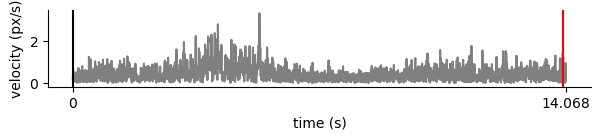

In [11]:
plt.figure(figsize = (7,1))
plt.plot(vel_lab3,color='gray');
plt.axvline(t_bite_start*n/T,color='k'); plt.axvline(t_bite_end*n/T,color='r');
sns.despine();
plt.xticks([0,n],[0,T]); plt.xlabel('time (s)'); plt.ylabel('velocity (px/s)');
plt.savefig(plot_folder+f"panel_{videoIdx}_"+"bite_segmentation.pdf",bbox_inches = "tight")

## Moving to Labium Frame

In [13]:
corrDf

,bite,time [s],insert_length,straightness,lab_angle,pal_angle
0,0,0.000,NaN,NaN,NaN,NaN
1,0,0.004,NaN,NaN,NaN,NaN
2,0,0.008,NaN,NaN,NaN,NaN
3,0,0.012,NaN,NaN,NaN,NaN
4,0,0.016,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
781,0,3.124,NaN,NaN,NaN,NaN
782,0,3.128,NaN,NaN,NaN,NaN
783,0,3.132,NaN,NaN,NaN,NaN
784,0,3.136,NaN,NaN,NaN,NaN


In [24]:
time = np.linspace(0,T,n)

In [10]:
parts = ('tar1','tar2','tar3','lab1','lab2','lab3','pal1','pal2','pal3')

In [11]:
derDf = bt.derive(legDf,T,0,T,ctr='lab3')

TypeError: derive() got multiple values for argument 'ctr'

In [27]:
len(time)

3517

In [28]:
derDf

bodyparts        tar1                               tar2              \
coords              x           y likelihood           x           y   
0         -292.294556 -127.027039   0.999973 -191.247986 -120.860657   
1         -292.088593 -126.689941   0.999977 -191.492462 -120.808655   
2         -292.195984 -126.308777   0.999979 -191.448090 -120.783936   
3         -291.929199 -126.098633   0.999976 -191.574341 -120.570251   
4         -292.272552 -125.424622   0.999974 -191.470398 -119.922974   
...               ...         ...        ...         ...         ...   
3488      -296.775505 -111.618958   0.999972 -195.586121 -111.203857   
3489      -296.092751 -111.738831   0.999973 -194.718628 -111.456970   
3490      -294.810318 -112.152710   0.999971 -193.838745 -111.757202   
3491      -294.529457 -112.458191   0.999972 -193.566193 -112.099854   
3492      -294.848694 -113.299622   0.999973 -193.779114 -112.928040   

bodyparts                  tar3                              lab1  ...  \
coords    likelihood          x           y likelihood          x  ...   
0           0.999970 -68.963440 -110.761353   0.999994 -30.014282  ...   
1           0.999976 -68.864319 -110.618042   0.999994 -30.035034  ...   
2           0.999978 -68.764404 -110.487915   0.999994 -30.089844  ...   
3           0.999982 -68.725525 -110.083618   0.999993 -29.954468  ...   
4           0.999979 -68.720825 -109.622131   0.999993 -30.032959  ...   
...              ...        ...         ...        ...        ...  ...   
3488        0.999951 -72.384857 -110.478699   0.999985 -32.742798  ...   
3489        0.999953 -71.345490 -110.926941   0.999982 -31.798523  ...   
3490        0.999954 -70.193848 -111.392578   0.999980 -30.672699  ...   
3491        0.999951 -69.887787 -111.871643   0.999979 -30.415771  ...   
3492        0.999953 -70.073486 -112.489624   0.999980 -30.726868  ...   

bodyparts      lab2             lab3                 pal1             \
coords        speed norm_speed speed norm_speed     speed norm_speed   
0               NaN        NaN   NaN        NaN       NaN        NaN   
1          0.538571   0.115301   0.0        NaN  0.422957   0.016836   
2          0.637647   0.136512   0.0        NaN  1.456251   0.057966   
3          0.738317   0.158064   0.0        NaN  1.500206   0.059716   
4          0.945100   0.202334   0.0        NaN  0.318420   0.012675   
...             ...        ...   ...        ...       ...        ...   
3488       0.857248   0.183526   0.0        NaN  2.674629   0.106463   
3489       0.905886   0.193939   0.0        NaN  0.983669   0.039155   
3490       1.213639   0.259825   0.0        NaN  1.999702   0.079598   
3491       0.499893   0.107021   0.0        NaN  1.862792   0.074148   
3492       0.564983   0.120956   0.0        NaN  1.471631   0.058578   

bodyparts      pal2                 pal3             
coords        speed norm_speed     speed norm_speed  
0               NaN        NaN       NaN        NaN  
1          0.173301   0.088024  0.397579   0.040813  
2          0.116654   0.059252  0.494732   0.050786  
3          0.264879   0.134540  1.932604   0.198388  
4          0.475390   0.241464  0.883999   0.090745  
...             ...        ...       ...        ...  
3488       0.119143   0.060516  3.067685   0.314908  
3489       0.284570   0.144541  1.569703   0.161135  
3490       0.415481   0.211034  1.653029   0.169689  
3491       0.319830   0.162451  1.864035   0.191349  
3492       0.340325   0.172861  1.674164   0.171858  

[3493 rows x 45 columns]

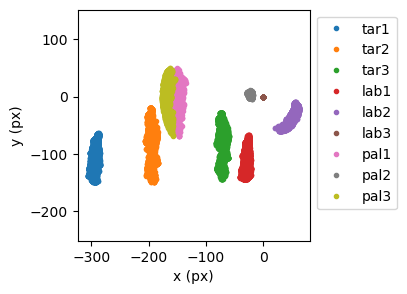

In [29]:
plt.figure(figsize = (3,3))
plt.axes().set_aspect('equal');
plt.plot(derDf.loc[:,(parts,('x'))].values,
         derDf.loc[:,(parts,('y'))].values,'.');
plt.axis('equal')
plt.legend(list(parts),bbox_to_anchor = (1,1));
plt.xlabel('x (px)'); plt.ylabel('y (px)');
plt.savefig(plot_folder+f"panel_{videoIdx}_"+"bodyparts_labium_frame_xy.pdf",bbox_inches = "tight")

In [11]:
# Load the video
video = bt.videoExtract(sep.join([vid_folder, vidfile]))
#video_bite = video[int(t_bite_start*n/T):int(t_bite_end*n/T),:,:,:]

## Panel 1

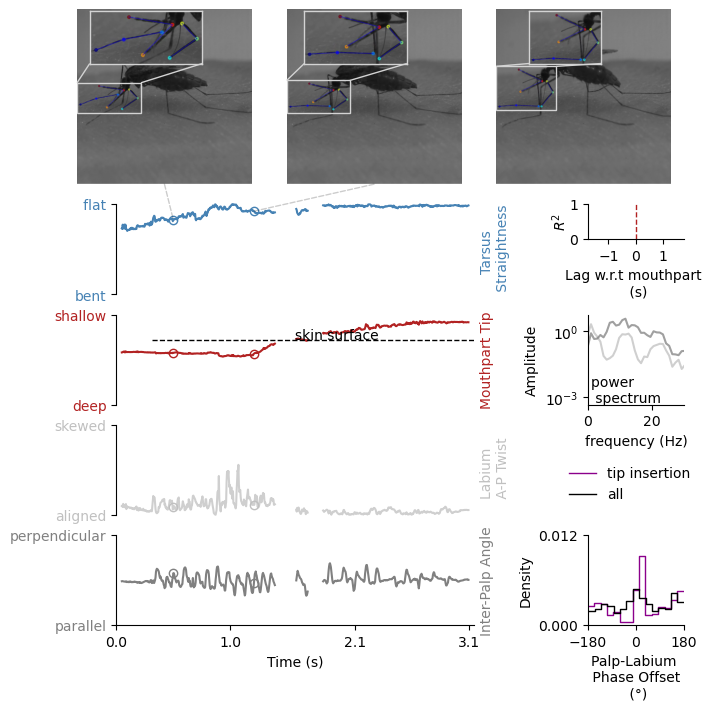

In [12]:
# === Color Settings ===
colors = {
    'insert': 'firebrick',
    'gut': 'rosybrown',
    'straight': 'steelblue',
    'twist': 'silver',
    'palp': 'grey'
}

fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(9, 12, width_ratios=[1]*12, height_ratios=[1]+[0.2]*8, hspace=0.4, wspace=0.2)

# === FRAME TIMEPOINTS ===
#timeinterval = [t_bite_start, t_bite_end]
#timeCond = (time >= timeinterval[0]) & (time <= timeinterval[1])

# === ax_insert: Mouthpart Insert Length ===
ax_insert = fig.add_subplot(gs[3:5, 1:8])
#y_insert = -bt.insert_length(derDf)
ax_insert.plot(corrDf['time [s]'], corrDf['insert_length'], color=colors['insert'], clip_on=False, zorder=-1)
#ax_insert.plot(time, y_insert, color=colors['insert'], alpha=0.5)
#ax_insert.text(-np.max(time[timeCond])/100, np.min(y_insert[timeCond])-0.2, "Mouthpart Tip", fontsize=10, color=colors['insert'])
ax_insert.set_ylabel("Mouthpart Tip", fontsize=10, color=colors['insert'])
ax_insert.yaxis.set_label_position("right")
ax_insert.text(np.median(corrDf['time [s]']), 0.02, "skin surface", fontsize=10, color='k')
ax_insert.set_xlim(0, T)
ax_insert.set_ylim(-1, np.max(corrDf['insert_length']) + 0.1)
ax_insert.set_yticks([-1, np.max(corrDf['insert_length']) + 0.1])
#ax_insert.spines['left'].set_position(('outward', 25))
ax_insert.set_yticklabels(['deep', 'shallow'], color = colors['insert'])
ax_insert.axhline(y=0, xmin=0.1, color='black', linewidth=1, linestyle='--')
ax_insert.set_xticks([])
sns.despine(ax=ax_insert, bottom=True)

frame_indices = datasetDf[['frame1','frame2','frame3']].iloc[videoIdx].values#-int(t_bite_start*n/T) #[np.argmin(np.abs(time - t)) for t in frame_times]
frame_times = frame_indices * T/n
'''if np.sum((frame_times < 0) | (frame_times > t_bite))> 0:
    # Frame time indices and sorted values
    frame_times = np.sort([
        np.argmin(y_insert)*T/n,
        np.argmin(np.abs(y_insert - np.mean(y_insert)))*T/n,
        np.argmax(y_insert)*T/n
    ])
    frame_indices = [np.argmin(np.abs(time - t)) for t in frame_times]'''

# --- Helper function for marking frame times ---
def mark_open_circles(ax, y_data, color):
    for t in frame_times:
        idx = np.argmin(np.abs(corrDf['time [s]'] - t))
        ax.plot(corrDf['time [s]'].values[idx], y_data[idx], marker='o', color=color, fillstyle='none', linewidth=1, clip_on=False)

mark_open_circles(ax_insert, corrDf['insert_length'], colors['insert'])

# === ax_straight: Tarsus Straightness ===
ax_straight = fig.add_subplot(gs[1:3, 1:8])
ax_straight.plot(corrDf['time [s]'], corrDf['straightness'], color=colors['straight'], clip_on=False)
#ax_straight.text(-np.max(time[timeCond])/100, np.min(y_straight[timeCond])-0.2, "Tarsus Straightness", fontsize=10, color=colors['straight'])
ax_straight.set_ylabel("Tarsus \n Straightness", fontsize=10, color=colors['straight'])
ax_straight.yaxis.set_label_position("right")
ax_straight.set_ylim(0, 1)
ax_straight.set_yticks([0, 1])
#ax_straight.spines['left'].set_position(('outward', 35))
ax_straight.set_yticklabels(['bent', '   flat'], color = colors['straight'])
ax_straight.set_xlim(0, T)
ax_straight.set_xticks([])
sns.despine(ax=ax_straight, bottom=True)
mark_open_circles(ax_straight, corrDf['straightness'], colors['straight'])

# === ax_twist: Labium Twist ===
ax_twist = fig.add_subplot(gs[5:7, 1:8])
ax_twist.plot(corrDf['time [s]'], corrDf['lab_angle'], color=colors['twist'], linestyle='-', clip_on = False, alpha=0.75)
#ax_twist.text(np.mean(time[timeCond]), np.min(angle_lab_3d)-10, "Labium A-P Alignment", fontsize=10, color=colors['twist'])
ax_twist.set_ylabel("Labium \n A-P Twist", fontsize=10, color=colors['twist'])
ax_twist.yaxis.set_label_position("right")
ax_twist.set_xlim(0, T)
ax_twist.set_ylim(0, 45)
ax_twist.set_yticks([0, 45])
#ax_twist.spines['left'].set_position(('outward', 15))
ax_twist.set_yticklabels(['aligned', 'skewed'], color=colors['twist'])
ax_twist.set_xticks([])
sns.despine(ax=ax_twist, bottom=True)
mark_open_circles(ax_twist, corrDf['lab_angle'], colors['twist'])

# Gut Length if available
if 'gut' in derDf.columns.values[-1][0]:
    ax_gut = ax_insert.twinx()
    gl = bt.gut_length(derDf)
    ax_gut.plot(time[timeCond], gl, color=colors['gut'], clip_on=False, zorder=-1, alpha=0.5)
    ax_gut.set_ylim(0, 1)
    ax_gut.set_yticks([0, 1])
    #ax_gut.spines['right'].set_position(('outward', -5))
    mark_open_circles(ax_gut, gl, colors['gut'])
    sns.despine(ax=ax_gut, bottom=True, right=False, left=True)
    ax_gut.spines['right'].set_visible(True)
    ax_gut.set_yticklabels(['small', 'large'], color=colors['gut'], zorder=10)
    ax_gut.yaxis.set_ticks_position('right')
    ax_gut.yaxis.set_label_position('right')
    ax_gut.text(np.mean(time[timeCond]), np.mean(gl)-0.2, "Gut Size", fontsize=10, color=colors['gut'])
    

# === ax_palp: Inter-Palp Angle ===
ax_palp = fig.add_subplot(gs[7:9, 1:8])
ax_palp.plot(corrDf['time [s]'], corrDf['pal_angle'], color=colors['palp'], clip_on = False, linestyle='-')
#ax_palp.text(np.mean(time[timeCond]), np.min(angle_pal_3d)-20, "Inter-Palp Angle", fontsize=10, color=colors['palp'])
ax_palp.set_ylabel("Inter-Palp Angle", fontsize=10, color=colors['palp'])
ax_palp.yaxis.set_label_position("right")
#ax_palp.axhline(y=90, xmin=0 , xmax=1/time[timeCond].max(), clip_on=False, color='k', linewidth=1)
#ax_palp.text(0, 100, "1 sec", fontsize=10, color='k')
ax_palp.set_xlim(0, T)
ax_palp.set_ylim(0, 90)
ax_palp.set_yticks([0, 90])
#ax_palp.spines['left'].set_position(('outward', 5))
ax_palp.set_yticklabels(['parallel', 'perpendicular'], color = colors['palp'])
ax_palp.set_xticks([])
sns.despine(ax=ax_palp, bottom=False)
ax_palp.set_xticks(np.round(np.linspace(0, np.round(T,1), 4),1))
ax_palp.set_xlabel('Time (s)', fontsize=10)
mark_open_circles(ax_palp, corrDf['pal_angle'], colors['palp'])

#corrDf = pd.DataFrame(np.array([y_straight, y_insert, time[timeCond], angle_lab_3d, angle_pal_3d]).T, columns=['straightness', 'insert_length', 'time [s]', 'lab_angle', 'pal_angle']).dropna()
ax_str_ins = fig.add_subplot(gs[1, 10:])
ax_str_ins.set_xlim(-1.75, 1.75)
ax_str_ins.set_ylim(0, 1)
lags, r_sq = bt.get_lag_curve(corrDf)
lag_at_max_corr = lags[np.argmax(r_sq)]
ax_str_ins.plot(lags, r_sq, color = 'k', linewidth=1)
ax_str_ins.set_xlabel('Lag w.r.t mouthpart \n (s)', fontsize =10)
ax_str_ins.set_ylabel('$R^2$', labelpad=0)
ax_str_ins.axvline(x=lag_at_max_corr, color=colors['straight'], linestyle='--', linewidth=1)
ax_str_ins.axvline(x=0, color=colors['insert'], linestyle='--', linewidth=1)
sns.despine(ax = ax_str_ins)

#checks whether there are at least a certain duration of tip removal or insertion
removal = bt.zoom_str_mot(corrDf, zoomInterval = T/10)
insertion = bt.zoom_str_mot(corrDf, zoomInterval = T/10, dir = 'insertion', mov_percentile= 80)

ax_pal_lab = fig.add_subplot(gs[7:9, 10:])
ax_pal_lab.set_xticks([-180, 0, 180])

if np.sum(removal)>0:
    sns.histplot(bt.deltaPhase(corrDf, removal = True), bins = 15, ax = ax_pal_lab, element="step", stat="density", fill = False, color = 'palevioletred', linewidth=1, label = 'tip removal')
if np.sum(insertion)>0: 
    sns.histplot(bt.deltaPhase(corrDf, removal = True, dir = 'insertion', mov_percentile=80
                               ), bins = 15, ax = ax_pal_lab, element="step", stat="density", fill = False, color = 'darkmagenta', linewidth=1, label = 'tip insertion')

sns.histplot(bt.deltaPhase(corrDf), bins = 15, ax = ax_pal_lab, element="step", stat="density", fill = False, color = 'k', linewidth=1, label = 'all')

if (np.sum(removal) > 0) | (np.sum(insertion) > 0):
    ax_pal_lab.legend(loc='upper right', bbox_to_anchor = (1.2, 1.9), fontsize=10, frameon=False)
else:
    ax_pal_lab.legend([], [], frameon=False)


ax_pal_lab.set_xlabel('Palp-Labium \n Phase Offset \n (°)', fontsize=10)
ax_pal_lab.set_xlim(-180, 180)
ax_pal_lab.set_yticks([0, 0.012])
ax_pal_lab.set_ylabel('Density', fontsize=10)#, #labelpad=-10)
sns.despine(ax = ax_pal_lab)

if (np.sum(removal) > 0) | (np.sum(insertion) > 0):
    ax_spec = fig.add_subplot(gs[3:5, 10:])
else:
    ax_spec = fig.add_subplot(gs[3:6, 10:])

# ax_spec gets the middle cell with more vertical space
#ax_spec = fig.add_subplot(gs[3:5, 10:])
f, Pxx_den = signal.welch(corrDf['lab_angle'].dropna(), fs=n/T)
f1, Pxx_den1 = signal.welch(corrDf['pal_angle'].dropna(), fs=n/T)
ax_spec.semilogy(f, Pxx_den, color=colors['twist'], linewidth=1.5, alpha=0.75)   # Horizontal log scale
ax_spec.semilogy(f1, Pxx_den1, color=colors['palp'], linewidth=1.5, alpha=0.75)   # Horizontal log scale
ax_spec.set_xlabel('frequency (Hz)')
ax_spec.set_yticks([0.001, 1])
ax_spec.text(1, np.min([np.min(Pxx_den), np.min(Pxx_den1)])*0.8, 'power \n spectrum', fontsize = 10, color = 'k')
ax_spec.set_xlim(0, 30)
ax_spec.set_ylabel('Amplitude', fontsize=10)
sns.despine(ax = ax_spec)


try: 
    removal = bt.zoom_str_mot(corrDf, zoomInterval = 1, which = 2)
except: 
    removal = bt.zoom_str_mot(corrDf, zoomInterval = 1, which = 1)
insertion = bt.zoom_str_mot(corrDf, zoomInterval = 1, dir = 'insertion', mov_percentile= 80)
if removal.sum() > 0:
    toplot = removal
elif insertion.sum() > 0:
    toplot = insertion
else: 
    toplot = None   
if (T>8) & (toplot is not None): 
    for ax, col, key, anchor in [(ax_palp, 'palp', 'pal_angle', -0.1), (ax_twist, 'twist', 'lab_angle', 0.1)]:
        # Get time range
        t_start = corrDf['time [s]'][toplot].min()
        t_end = corrDf['time [s]'][toplot].max()

        # Add inset
        ax_in = inset_axes(ax, width="30%", height="25%", bbox_to_anchor=(0.6, anchor, 1, 1),
                        bbox_transform=ax.transAxes, loc='upper left', borderpad=0)
        ax_in.plot(corrDf['time [s]'][toplot], corrDf[key][toplot], color=colors[col], alpha=0.7)
        ax_in.set_xlim(t_start, t_end)
        ax_in.set_ylim(corrDf[key][toplot].min(), corrDf[key][toplot].max())
        ax_in.set_xticks([]); ax_in.set_yticks([]); ax_in.set_facecolor('white')
        [s.set_edgecolor('palevioletred') for s in ax_in.spines.values()] if removal.sum() > 0 else [s.set_edgecolor('darkmagenta') for s in ax_in.spines.values()]

        # Highlight zoom region on main plot
        v0, v1 = corrDf[key][toplot].min(), corrDf[key][toplot].max()
        ax.axvspan(t_start, t_end, ymin=(v0-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                        ymax=(v1-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                        fill = False, edgecolor='palevioletred', linewidth=1) if removal.sum() > 0 else \
            ax.axvspan(t_start, t_end, ymin=(v0-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                        ymax=(v1-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                        fill = False, edgecolor='darkmagenta', linewidth=1)
        

# === Video Stills with Insets ===
for i, (t, frame) in enumerate(zip(frame_times, frame_indices)):
    ax_vid = fig.add_subplot(gs[0, 4*i:4*(i+1)])
    ax_vid.imshow(video[frame])
    ax_vid.axis('off')

    # Zoom inset
    idx = np.argmin(np.abs(corrDf['time [s]'] - t)) #+ t_bite_start*n/T
    partslist = tuple(pd.Series(parts)[pd.Series(parts).str.contains('lab|pal|tar')].tolist())
    x1 = legDf.loc[idx, (partslist, 'x')].min() - 20
    x2 = legDf.loc[idx, (partslist, 'x')].max() + 20
    y1 = legDf.loc[idx, (partslist, 'y')].min() - 20
    y2 = legDf.loc[idx, (partslist, 'y')].max() + 20

    axins = inset_axes(ax_vid, width='75%', height='30%', loc='upper left', bbox_to_anchor=[0.02, -0.01, 1, 1], bbox_transform=ax_vid.transAxes, borderpad=0)
    axins.imshow(video[frame])
    axins.set_xlim(x1, x2)
    axins.set_ylim(y2, y1)
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_facecolor('lightgrey')
    for spine in axins.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)
    mark_inset(ax_vid, axins, loc1=3, loc2=4, fc="none", ec="lightgrey", lw=1, zorder=0)

    # Connection to time series
    con = ConnectionPatch(xyA=(len(video[0])//2, len(video[0])),
                          xyB=(t, corrDf['straightness'][frame]), coordsB=ax_straight.transData,
                          axesA=ax_vid, axesB=ax_straight, coordsA=ax_vid.transData,
                          color='k', linewidth=1, linestyle='--', alpha=0.2)
    fig.add_artist(con)
plt.savefig(plot_folder + f"panel_{videoIdx}.pdf", bbox_inches='tight', dpi=300)

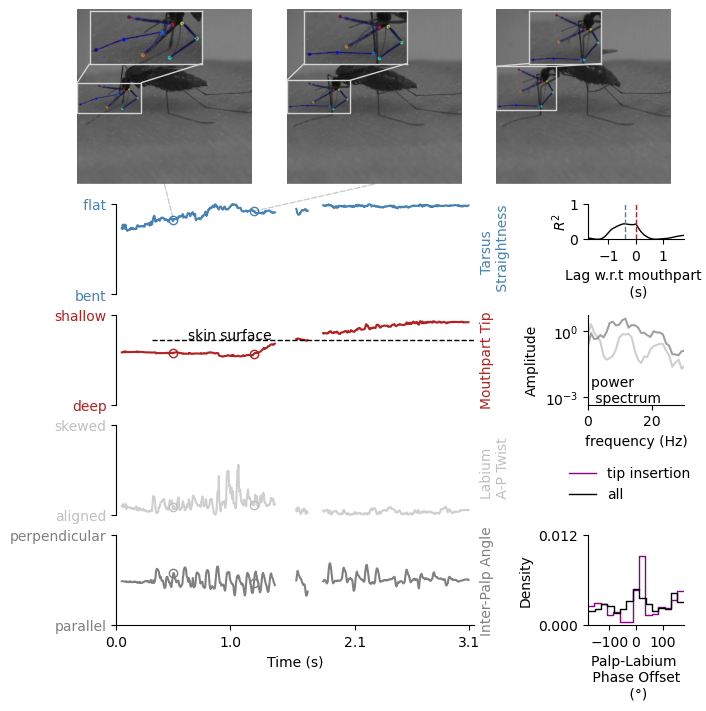

In [15]:
# === Color Settings ===
colors = {
    'insert': 'firebrick',
    'gut': 'rosybrown',
    'straight': 'steelblue',
    'twist': 'silver',
    'palp': 'grey'
}

fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(9, 12, width_ratios=[1]*12, height_ratios=[1]+[0.2]*8, hspace=0.4, wspace=0.2)

# === ax_insert: Mouthpart Insert Length ===
ax_insert = fig.add_subplot(gs[3:5, 1:8])
ax_insert.plot(corrDf['time [s]'], corrDf['insert_length'], color=colors['insert'], clip_on=False, zorder=-1)
ax_insert.set_ylabel("Mouthpart Tip", fontsize=10, color=colors['insert'])
ax_insert.yaxis.set_label_position("right")
ax_insert.text(np.percentile(corrDf['time [s]'], 20), 0.02, "skin surface", fontsize=10, color='k')
ax_insert.set_xlim(0, T)
ax_insert.set_ylim(-1, np.max(corrDf['insert_length']) + 0.1)
ax_insert.set_yticks([-1, np.max(corrDf['insert_length']) + 0.1])
ax_insert.set_yticklabels(['deep', 'shallow'], color=colors['insert'])
ax_insert.axhline(y=0, xmin=0.1, color='black', linewidth=1, linestyle='--')
ax_insert.set_xticks([])
sns.despine(ax=ax_insert, bottom=True)

frame_indices = datasetDf[['frame1','frame2','frame3']].iloc[videoIdx].values
frame_times = frame_indices * T/n

def mark_open_circles(ax, y_data, color):
    for t in frame_times:
        idx = np.argmin(np.abs(corrDf['time [s]'] - t))
        ax.plot(corrDf['time [s]'].values[idx], y_data[idx], marker='o', color=color, fillstyle='none', linewidth=1, clip_on=False)

mark_open_circles(ax_insert, corrDf['insert_length'], colors['insert'])

# === ax_straight: Tarsus Straightness ===
ax_straight = fig.add_subplot(gs[1:3, 1:8])
ax_straight.plot(corrDf['time [s]'], corrDf['straightness'], color=colors['straight'], clip_on=False)
ax_straight.set_ylabel("Tarsus \n Straightness", fontsize=10, color=colors['straight'])
ax_straight.yaxis.set_label_position("right")
ax_straight.set_ylim(0, 1)
ax_straight.set_yticks([0, 1])
ax_straight.set_yticklabels(['bent', '   flat'], color=colors['straight'])
ax_straight.set_xlim(0, T)
ax_straight.set_xticks([])
sns.despine(ax=ax_straight, bottom=True)
mark_open_circles(ax_straight, corrDf['straightness'], colors['straight'])

# === ax_twist: Labium Twist ===
ax_twist = fig.add_subplot(gs[5:7, 1:8])
ax_twist.plot(corrDf['time [s]'], corrDf['lab_angle'], color=colors['twist'], linestyle='-', clip_on=False, alpha=0.75)
ax_twist.set_ylabel("Labium \n A-P Twist", fontsize=10, color=colors['twist'])
ax_twist.yaxis.set_label_position("right")
ax_twist.set_xlim(0, T)
ax_twist.set_ylim(0, 45)
ax_twist.set_yticks([0, 45])
ax_twist.set_yticklabels(['aligned', 'skewed'], color=colors['twist'])
ax_twist.set_xticks([])
sns.despine(ax=ax_twist, bottom=True)
mark_open_circles(ax_twist, corrDf['lab_angle'], colors['twist'])

# === Gut Length (Overlay) ===
if 'gut' in derDf.columns.values[-1][0]:
    ax_gut = ax_insert.twinx()
    ax_gut.plot(corrDf['time [s]'], corrDf['gl'], color=colors['gut'], alpha=0.5, clip_on=False, zorder=-1)
    ax_gut.set_ylim(0, 1)
    ax_gut.set_yticks([0, 1])
    mark_open_circles(ax_gut, gl, colors['gut'])
    sns.despine(ax=ax_gut, bottom=True, right=False, left=True)
    ax_gut.spines['right'].set_visible(True)
    ax_gut.set_yticklabels(['small', 'large'], color=colors['gut'], zorder=10)
    ax_gut.yaxis.set_ticks_position('right')
    ax_gut.yaxis.set_label_position('right')

# === ax_palp: Inter-Palp Angle ===
ax_palp = fig.add_subplot(gs[7:9, 1:8])
ax_palp.plot(corrDf['time [s]'], corrDf['pal_angle'], color=colors['palp'], clip_on=False, linestyle='-')
ax_palp.set_ylabel("Inter-Palp Angle", fontsize=10, color=colors['palp'])
ax_palp.yaxis.set_label_position("right")
ax_palp.set_xlim(0, T)
ax_palp.set_ylim(0, 90)
ax_palp.set_yticks([0, 90])
ax_palp.set_yticklabels(['parallel', 'perpendicular'], color=colors['palp'])
ax_palp.set_xticks(np.round(np.linspace(0, np.round(T, 1), 4), 1))
ax_palp.set_xlabel('Time (s)', fontsize=10)
sns.despine(ax=ax_palp, bottom=False)
mark_open_circles(ax_palp, corrDf['pal_angle'], colors['palp'])

# === Correlation Plot ===
ax_str_ins = fig.add_subplot(gs[1, 10:])
ax_str_ins.set_xlim(-1.75, 1.75)
ax_str_ins.set_ylim(0, 1)
lags, r_sq = bt.get_lag_curve(corrDf)
lag_at_max_corr = lags[np.argmax(r_sq)]
ax_str_ins.plot(lags, r_sq, color='k', linewidth=1)
ax_str_ins.set_xlabel('Lag w.r.t mouthpart \n (s)', fontsize=10)
ax_str_ins.set_ylabel('$R^2$', labelpad=0)
ax_str_ins.axvline(x=lag_at_max_corr, color=colors['straight'], linestyle='--', linewidth=1)
ax_str_ins.axvline(x=0, color=colors['insert'], linestyle='--', linewidth=1)
sns.despine(ax=ax_str_ins)

# === Phase Offset Histograms ===
removal = bt.zoom_str_mot(corrDf, zoomInterval=T/10)
insertion = bt.zoom_str_mot(corrDf, zoomInterval=T/10, dir='insertion', mov_percentile=80)

ax_pal_lab = fig.add_subplot(gs[7:9, 10:])
if np.sum(removal) > 0:
    sns.histplot(bt.deltaPhase(corrDf, removal=True), bins=15, ax=ax_pal_lab, element="step", stat="density", fill=False, color='palevioletred', linewidth=1, label='tip removal')
if np.sum(insertion) > 0:
    sns.histplot(bt.deltaPhase(corrDf, removal=True, dir='insertion', mov_percentile=80), bins=15, ax=ax_pal_lab, element="step", stat="density", fill=False, color='darkmagenta', linewidth=1, label='tip insertion')
sns.histplot(bt.deltaPhase(corrDf), bins=15, ax=ax_pal_lab, element="step", stat="density", fill=False, color='k', linewidth=1, label='all')
if (np.sum(removal) > 0) | (np.sum(insertion) > 0):
    ax_pal_lab.legend(loc='upper right', bbox_to_anchor=(1.2, 1.9), fontsize=10, frameon=False)
else:
    ax_pal_lab.legend([], [], frameon=False)
ax_pal_lab.set_xlabel('Palp-Labium \n Phase Offset \n (°)', fontsize=10)
ax_pal_lab.set_xlim(-180, 180)
ax_pal_lab.set_yticks([0, 0.012])
ax_pal_lab.set_ylabel('Density', fontsize=10)
sns.despine(ax=ax_pal_lab)

# === Power Spectrum ===
ax_spec = fig.add_subplot(gs[3:5, 10:]) if (np.sum(removal) > 0) | (np.sum(insertion) > 0) else fig.add_subplot(gs[3:6, 10:])
f, Pxx_den = signal.welch(corrDf['lab_angle'].dropna(), fs=n/T)
f1, Pxx_den1 = signal.welch(corrDf['pal_angle'].dropna(), fs=n/T)
ax_spec.semilogy(f, Pxx_den, color=colors['twist'], linewidth=1.5, alpha=0.75)
ax_spec.semilogy(f1, Pxx_den1, color=colors['palp'], linewidth=1.5, alpha=0.75)
ax_spec.set_xlabel('frequency (Hz)')
ax_spec.set_yticks([0.001, 1])
ax_spec.set_xlim(0, 30)
ax_spec.set_ylabel('Amplitude', fontsize=10)
ax_spec.text(1, np.min([np.min(Pxx_den), np.min(Pxx_den1)])*0.8, 'power \n spectrum', fontsize=10, color='k')
sns.despine(ax=ax_spec)

# === Inset for Active Movements ===
try:
    removal = bt.zoom_str_mot(corrDf, zoomInterval=1, which=2)
except:
    removal = bt.zoom_str_mot(corrDf, zoomInterval=1, which=1)
insertion = bt.zoom_str_mot(corrDf, zoomInterval=1, dir='insertion', mov_percentile=80)
toplot = removal if removal.sum() > 0 else insertion if insertion.sum() > 0 else None
if (T > 8) & (toplot is not None):
    for ax, col, key, anchor in [(ax_palp, 'palp', 'pal_angle', -0.1), (ax_twist, 'twist', 'lab_angle', 0.1)]:
        t_start = corrDf['time [s]'][toplot].min()
        t_end = corrDf['time [s]'][toplot].max()
        ax_in = inset_axes(ax, width="30%", height="25%", bbox_to_anchor=(0.6, anchor, 1, 1), bbox_transform=ax.transAxes, loc='upper left', borderpad=0)
        ax_in.plot(corrDf['time [s]'][toplot], corrDf[key][toplot], color=colors[col], alpha=0.7)
        ax_in.set_xlim(t_start, t_end)
        ax_in.set_ylim(corrDf[key][toplot].min(), corrDf[key][toplot].max())
        ax_in.set_xticks([]); ax_in.set_yticks([])
        ax_in.set_facecolor('white')
        [s.set_edgecolor('palevioletred') for s in ax_in.spines.values()] if removal.sum() > 0 else [s.set_edgecolor('darkmagenta') for s in ax_in.spines.values()]
        ax.axvspan(t_start, t_end, ymin=(v0:=corrDf[key][toplot].min()-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                             ymax=(v1:=corrDf[key][toplot].max()-ax.get_ylim()[0])/(ax.get_ylim()[1]-ax.get_ylim()[0]),
                             fill=False, edgecolor='palevioletred' if removal.sum() > 0 else 'darkmagenta', linewidth=1)

# === Video Stills with Insets ===
for i, (t, frame) in enumerate(zip(frame_times, frame_indices)):
    ax_vid = fig.add_subplot(gs[0, 4*i:4*(i+1)])
    ax_vid.imshow(video[frame])
    ax_vid.axis('off')
    idx = np.argmin(np.abs(corrDf['time [s]'] - t))
    partslist = tuple(pd.Series(parts)[pd.Series(parts).str.contains('lab|pal|tar')].tolist())
    x1 = legDf.loc[idx, (partslist, 'x')].min() - 20
    x2 = legDf.loc[idx, (partslist, 'x')].max() + 20
    y1 = legDf.loc[idx, (partslist, 'y')].min() - 20
    y2 = legDf.loc[idx, (partslist, 'y')].max() + 20
    axins = inset_axes(ax_vid, width='75%', height='30%', loc='upper left', bbox_to_anchor=[0.02, -0.01, 1, 1], bbox_transform=ax_vid.transAxes, borderpad=0)
    axins.imshow(video[frame])
    axins.set_xlim(x1, x2)
    axins.set_ylim(y2, y1)
    axins.set_xticks([]); axins.set_yticks([])
    axins.set_facecolor('lightgrey')
    for spine in axins.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)
    mark_inset(ax_vid, axins, loc1=3, loc2=4, fc="none", ec="lightgrey", lw=1, zorder=0)
    con = ConnectionPatch(xyA=(len(video[0])//2, len(video[0])),
                          xyB=(t, corrDf['straightness'][frame]), coordsB=ax_straight.transData,
                          axesA=ax_vid, axesB=ax_straight, coordsA=ax_vid.transData,
                          color='k', linewidth=1, linestyle='--', alpha=0.2)
    fig.add_artist(con)

# === Save Figure ===
plt.savefig(plot_folder + f"panel_{videoIdx}.pdf", bbox_inches='tight', dpi=300)

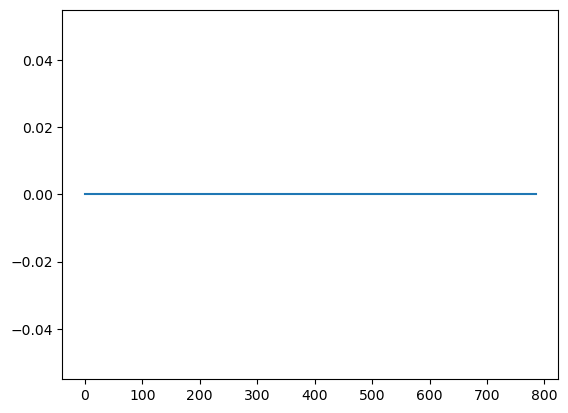

In [25]:
plt.plot(bt.zoom_str_mot(corrDf, zoomInterval=T/10))

In [15]:
corrDf[['lab_angle', 'pal_angle']].dropna()

,lab_angle,pal_angle
12,4.547078,44.051719
13,4.519123,44.184470
14,3.968335,44.011181
15,5.571794,43.936269
16,5.017284,43.824248
...,...,...
769,2.579070,45.773681
770,2.527870,45.899459
771,2.463278,45.943760
772,2.458596,45.408882


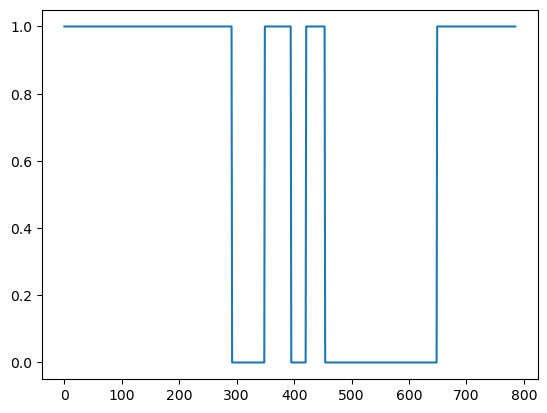

In [23]:
plt.plot(bt.straightness_motion(corrDf, dir = 'insertion', mov_percentile=80, phase= 'late', phase_time = 1.5))

In [52]:
removal = bt.straightness_motion(corrDf, dir = 'removal')

In [111]:
phase_time = 1
T = int(phase_time * len(corrDf)/corrDf['time [s]'].max())

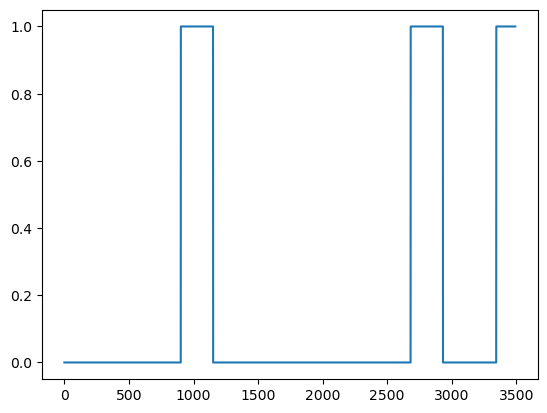

In [ ]:
from skimage.measure import label
T = int(phase_time * len(corrDf)/corrDf['time [s]'].max())
labels = label(removal)  # Label once
rem = removal.copy()
for l in np.unique(labels):
    if l == 0:
        continue  # 0 is background
    inds = np.where(labels == l)[0]
    if phase == 'late':
        if len(inds) > T:
            rem[inds[:len(inds)-T]] = False
    elif phase == 'early':
        if T < len(inds):
            rem[inds[T:]] = False
plt.plot(rem)

In [ ]:
removal = bt.straightness(corrDf, zoomInterval = 1.5
                          
                          , mov_percentile= 40)

In [ ]:
corrDf['time [s]']

In [ ]:
plt.plot(removal)
plt.plot(corrDf['insert_length'])

In [ ]:
def deltaPhase(corrDf, signal1 = 'pal_angle', signal2 = 'lab_angle', filt_win = 0.01, cutoffHz = 7.5, removal= False, filt_removal = 1, mov_percentile = 50, dir = 'removal'):
    """
    Calculate the phase difference between two signals.
    """
    fs = len(corrDf)/np.max(corrDf['time [s]'])  # Sampling frequency (Hz)
    filt_win = round(filt_win * fs) | 1 # Convert window size to samples
    if removal:
        removal = bt.straightness_motion(corrDf, filt_removal=filt_removal, mov_percentile=mov_percentile, dir=dir)
    else:
        removal = np.ones(len(corrDf), dtype=bool)
    signal1vals = corrDf[signal1].values[removal]
    signal2vals = corrDf[signal2].values[removal]
    dPh = np.rad2deg(sp.signal.medfilt(np.unwrap((bt.butterworth_filter_subtract_hilbert_phase(signal1vals, cutoffHz, 
                            fs)-bt.butterworth_filter_subtract_hilbert_phase(signal2vals, cutoffHz
                                                                           , fs))), filt_win)%(2*np.pi))
    return bt.butterworth_filter_subtract_hilbert_phase(signal1vals, cutoffHz, 
                            fs)

In [ ]:
from scipy.signal import butter, filtfilt, hilbert
import numpy as np

# Normalize input
signal = (signal - np.nanmin(signal)) / (np.nanmax(signal) - np.nanmin(signal))

# Low-pass filter
nyquist = 0.5 * fs
normal_cutoff = cutoff / nyquist
b, a = butter(order, normal_cutoff, btype='low')
filtered = filtfilt(b, a, signal)


In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sp.ndimage.gaussian_filter1d(corrDf['lab_angle'], 1.5))
ax.plot(sp.ndimage.gaussian_filter1d(corrDf['pal_angle'], 1.5))
ax2 = ax.twinx()
#ax2.plot(corrDf['insert_length'])


plt.xlim(2500, 3000)

In [ ]:
1/np.nanmedian(corrDf['time [s]'].diff())

In [ ]:
plt.plot(np.rad2deg(((np.angle(hilbert(apply_bandpass_filter(corrDf['lab_angle'], 5, 20, fs=n/T)))-np.angle(hilbert(apply_bandpass_filter(corrDf['pal_angle'], 5, 20, fs=n/T))))-np.pi)%(2*np.pi)-np.pi
         ), '.')
plt.xlim(0, None)

In [ ]:
plt.plot(sp.ndimage.gaussian_filter1d(np.abs((np.unwrap(np.angle(hilbert(apply_bandpass_filter(corrDf['lab_angle'], 5, 20, fs=n/T))))-np.unwrap(np.angle(hilbert(apply_bandpass_filter(corrDf['pal_angle'], 5, 20, fs=n/T))))-np.pi) % (2*np.pi) - np.pi), 0.1))

#plt.plot()

AttributeError: module 'bites' has no attribute 'estimte_3d_labial_twist'

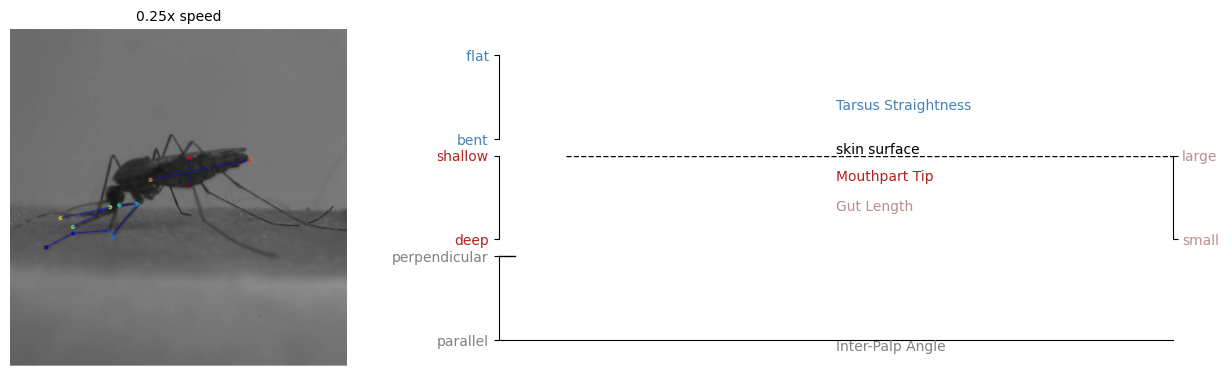

In [53]:
playbackspeed = 0.25 #x
twist = False

# --- Setup ---
colors = {
    'insert': 'firebrick',
    'gut': 'rosybrown',
    'straight': 'steelblue',
    'twist': 'silver',
    'palp': 'grey'
}

fig = plt.figure(figsize=(15, 5))
gs = fig.add_gridspec(8, 2, width_ratios=[1, 2], height_ratios=[0.2]*8, hspace=0.5, wspace=0.3)

# === Video frame (left side: rows 0-9, columns 0-4) ===
ax_vid = fig.add_subplot(gs[:, 0])
ax_vid.set_title(f'{playbackspeed}x speed', fontsize=10)
im = ax_vid.imshow(video_bite[0])
ax_vid.axis('off')

# === Time-Series Axes (right side: columns 5-11) ===
# Tarsus Straightness
ax_straight = fig.add_subplot(gs[1:3, 1])
line_straight, = ax_straight.plot([], [], color=colors['straight'], clip_on=False)
ax_straight.set_xlim(0, t_bite)
ax_straight.set_ylim(0, 1)
ax_straight.set_yticks([0, 1])
ax_straight.set_yticklabels(['bent', '   flat'], color=colors['straight'])
ax_straight.text(np.mean(time[timeCond]), np.min(y_straight[timeCond])-0.2, "Tarsus Straightness", fontsize=10, color=colors['straight'])
ax_straight.set_xticks([])
sns.despine(ax=ax_straight, bottom=True)

# Mouthpart Insertion
ax_insert = fig.add_subplot(gs[3:5, 1])
line_insert, = ax_insert.plot([], [], color=colors['insert'], clip_on=False)
ax_insert.set_xlim(0, t_bite)
ax_insert.set_ylim(-1, 0)
ax_insert.set_yticks([-1, 0])
ax_insert.set_yticklabels(['deep', 'shallow'], color=colors['insert'])
ax_insert.axhline(y=0, xmin=0.1, color='black', linewidth=1, linestyle='--')
ax_insert.text(np.mean(time[timeCond]), np.min(y_insert[timeCond])-0.2, "Mouthpart Tip", fontsize=10, color=colors['insert'])
ax_insert.text(np.median(time[timeCond]), 0.02, "skin surface", fontsize=10, color='k')
ax_insert.set_xticks([])
sns.despine(ax=ax_insert, bottom=True)

# Labium Twist
if twist:
    ax_twist = fig.add_subplot(gs[5:7, 1])
    line_twist, = ax_twist.plot([], [], color=colors['twist'], linestyle='-', alpha=0.75)
    ax_twist.set_xlim(0, t_bite)
    ax_twist.set_ylim(-90, 90)
    ax_twist.set_yticks([-90, 90])
    ax_twist.set_yticklabels(['rightward', 'leftward'], color=colors['twist'])
    ax_twist.text(np.mean(time[timeCond]), np.min(angle_lab_3d)-30, "Labium Twist", fontsize=10, color=colors['twist'])
    ax_twist.set_xticks([])
    sns.despine(ax=ax_twist, bottom=True)

# Inter-Palp Angle
    ax_palp = fig.add_subplot(gs[7:9, 1])
else:
    ax_palp = fig.add_subplot(gs[5:7, 1])
line_palp, = ax_palp.plot([], [], color=colors['palp'], linestyle='-')
ax_palp.set_xlim(0, t_bite)
ax_palp.set_ylim(0, 90)
ax_palp.set_yticks([0, 90])
ax_palp.set_yticklabels(['parallel', 'perpendicular'], color=colors['palp'])
ax_palp.text(np.mean(time[timeCond]), np.min(angle_pal_3d)-20, "Inter-Palp Angle", fontsize=10, color=colors['palp'])
ax_palp.set_xticks([])
sns.despine(ax=ax_palp, bottom=False)
ax_palp.axhline(y=90, xmin=0 , xmax=1/time[timeCond].max(), clip_on=False, color='k', linewidth=1)
#ax_palp.text(0.5, 100, "1 sec", fontsize=10, color='k')

# Optional Gut Length (shares y-axis with insert)
# Optional Gut Length if available
has_gut = 'gut' in derDf.columns.values[-1][0]
if has_gut:
    ax_gut = ax_insert.twinx()
    line_gut, = ax_gut.plot([], [], color=colors['gut'], alpha=0.5)
    ax_gut.set_ylim(0, 1)
    ax_gut.set_yticks([0, 1])
    ax_gut.set_yticklabels(['small', 'large'], color=colors['gut'])
    ax_gut.yaxis.set_ticks_position('right')
    ax_gut.text(np.mean(time[timeCond]), np.mean(gl[timeCond])-0.2, "Gut Length", fontsize=10, color=colors['gut'])
    sns.despine(ax=ax_gut, bottom=True, right=False, left=True)
    ax_gut.spines['right'].set_visible(True)
    ax_gut.yaxis.set_ticks_position('right')
    ax_gut.yaxis.set_label_position('right')

# Data
y_insert = -bt.insert_length(derDf)
y_straight = bt.straightness(derDf)
y_twist = bt.estimte_3d_labial_twist(derDf) * datasetDf['twist direction'].iloc[videoIdx]
y_palp = bt.estimate_3d_palp_angle(derDf, r=1.2, segment=2)
if has_gut:
    y_gut = bt.gut_length(derDf)

# === Animation Function ===
def animate(i):
    im.set_array(video_bite[i])
    line_insert.set_data(time[:i], y_insert[:i])
    line_straight.set_data(time[:i], y_straight[:i])
    line_twist.set_data(time[:i], y_twist[:i])
    line_palp.set_data(time[:i], y_palp[:i])
    if has_gut:
        line_gut.set_data(time[:i], y_gut[:i])
    return [im, line_insert, line_straight, line_twist, line_palp] + ([line_gut] if has_gut else [])

# === Create Animation ===
ani = animation.FuncAnimation(
    fig, animate,
    frames=np.arange(0, len(time), 5),
    interval=5*T/n*1000/playbackspeed,  # 1 x play speed
    repeat=False
)

# === Display in Notebook ===
html = HTML(ani.to_html5_video())
display(html)
plt.close()
ani.save(plot_folder + f"panel_{videoIdx}_playback_{playbackspeed}x.mp4", fps=n/(T*5)*playbackspeed, dpi=300, extra_args=['-vcodec', 'libx264'])